In [1]:
# Note using suppress to reduce constant red warning boxes
#TODO FABIO check if packages must be installed for reproducibility
suppressPackageStartupMessages({
    suppressWarnings({
        library(tidyverse)
        library(repr)
        library(tidymodels)
        library(tidyr)
        library(dplyr)
        library(workflowsets)
    })
})


In [2]:
# Size and general style set up
options(repr.plot.width = 6, repr.plot.height = 4, repr.matrix.max.rows = 7,readr.show_col_types = FALSE)

# Load Data
player_data <- read_csv("https://raw.githubusercontent.com/FabianoGLentini/player-subscription-ml/refs/heads/main/data/players.csv")
# TODO may not need session data
# session_data <- read_csv("")



# Data Science Project: Project Final Report


## Introduction:

## Methods & Results:

### Set up and intro to data: "TODO should rename later." 

In [3]:
# Wrangle data
player_df <- player_data |> # TODO must consider reworking a joining of some labels in gender etc due to low representaions
            select( subscribe, gender, played_hours, experience, Age) |>
            drop_na() |>
            mutate(
                subscribe = as_factor(subscribe),  # lgl -> fct for analysis and modeling
                gender = as_factor(gender),        # chr -> fct for analysis and modeling
                experience = as_factor(experience) # chr -> fct for analysis and modeling
            ) 
 # Removed row with NA values, as it may distort the model      

# TODO FABIO check if player_hours should adjust to use a binary outcome, 
# either played or didn't play at all, or if any of the predictor should be removed.


### Training and Analysis:

In [4]:
head(player_df) # TODO DELETE tmp  for set up 

subscribe,gender,played_hours,experience,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
TRUE,Male,30.3,Pro,9
TRUE,Male,3.8,Veteran,17
FALSE,Male,0.0,Veteran,17
TRUE,Female,0.7,Amateur,21
TRUE,Male,0.1,Regular,21
TRUE,Female,0.0,Amateur,17


In [5]:
set.seed(2025) # Don't change
# Prep for modelling
ply_df <- select(player_df, Age, subscribe, gender, played_hours)  # Exclude row_id & experience for modeling purposes

# Split step
player_split <- initial_split(ply_df, prop = 0.75, strata = subscribe) 
player_train <- training(player_split)
player_test <- testing(player_split)

# TODO FABIO CHECK boostraps() and if it would benefit our model with our small set

In [6]:
#TODO FABIO write up split/scale/recipe step reasoning
# 'initial split' Use Strata sub to balance the outcome for the bool prediction to avoid 
# imbalance in our test and train data split

# ... why use 75 25 split instead of 70/30 etc?

# ~ maybe explain why start with all predictors

In [7]:
#TODO FABIO ... search refractor options to reduce code clutter

# Recipes:
# Scale/Recipe

# Note: A = Age, G = gender and H = played_hours
# Recipe 01:
# Age + gender + played_hours
rc_AGH <- recipe(subscribe ~ Age + gender + played_hours, data = player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())
# # Recipe 02:
# Age + played_hours
rc_AH <- recipe(subscribe ~ Age + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 03:
# Age + gender 
rc_AG <- recipe(subscribe ~ Age + gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 04:
# gender + played_hours
rc_GH <- recipe(subscribe ~ gender + played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 05:
# Age
rc_A <- recipe(subscribe ~ Age, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 06:
# gender
rc_G <- recipe(subscribe ~ gender, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())

# Recipe 07:
# played_hours
rc_H <- recipe(subscribe ~ played_hours, player_train) |>
            step_dummy(all_nominal_predictors()) |>
            step_zv(all_predictors()) |> # Used to remove zero-variance variable after wrangling, gender_Other category had no rows associated to i 
            step_normalize(all_numeric_predictors())



In [8]:
#TODO FABIO breackdown hypothesis for each recipe variation ...?

In [9]:
# Spec set up
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#TODO FABIO ... search refractor options to reduce code clutter
# Check mean and standard error through collect_metrics


In [10]:
# TODO FABIO ~ write up spec use and impl of vfold..?

In [11]:
# TODO FABIO confirm that not having set.seed here is fine as long as set.seed above code cell goes first
# K-fold cross-validation
kfolds <- vfold_cv(player_train, v = 5, strata = subscribe)
k_grid = tibble(neighbors = seq(from = 1, to = 10, by = 1))


In [12]:
#TODO FABIO write reasonin + graph to show fold outcome
#Note the reason of using 10 10-fold is due to the small size data,
#hence it will improve the estimate and 

In [13]:
#TODO FABIO ... search refractor options to reduce code clutter/redundancy 
# Simplifying multi model testing: https://www.youtube.com/watch?v=YZqbOATpjM4&t=139s
# Workflow Step
workflow_set <- workflow_set(
    preproc = list(
        AGH = rc_AGH,
        AH = rc_AH,
        AG = rc_AG,
        GH = rc_GH,
        A = rc_A,
        G = rc_G,
        H = rc_H
    ),
    models = list(knn_spec),
)

# Tune workflow
set.seed(22)

ply_set_res <- workflow_map(
    workflow_set,
    "tune_grid",
    resamples = kfolds,
    grid = k_grid,
)


In [14]:
#TODO FABIO write workflow step use case/what it functionally is doing 

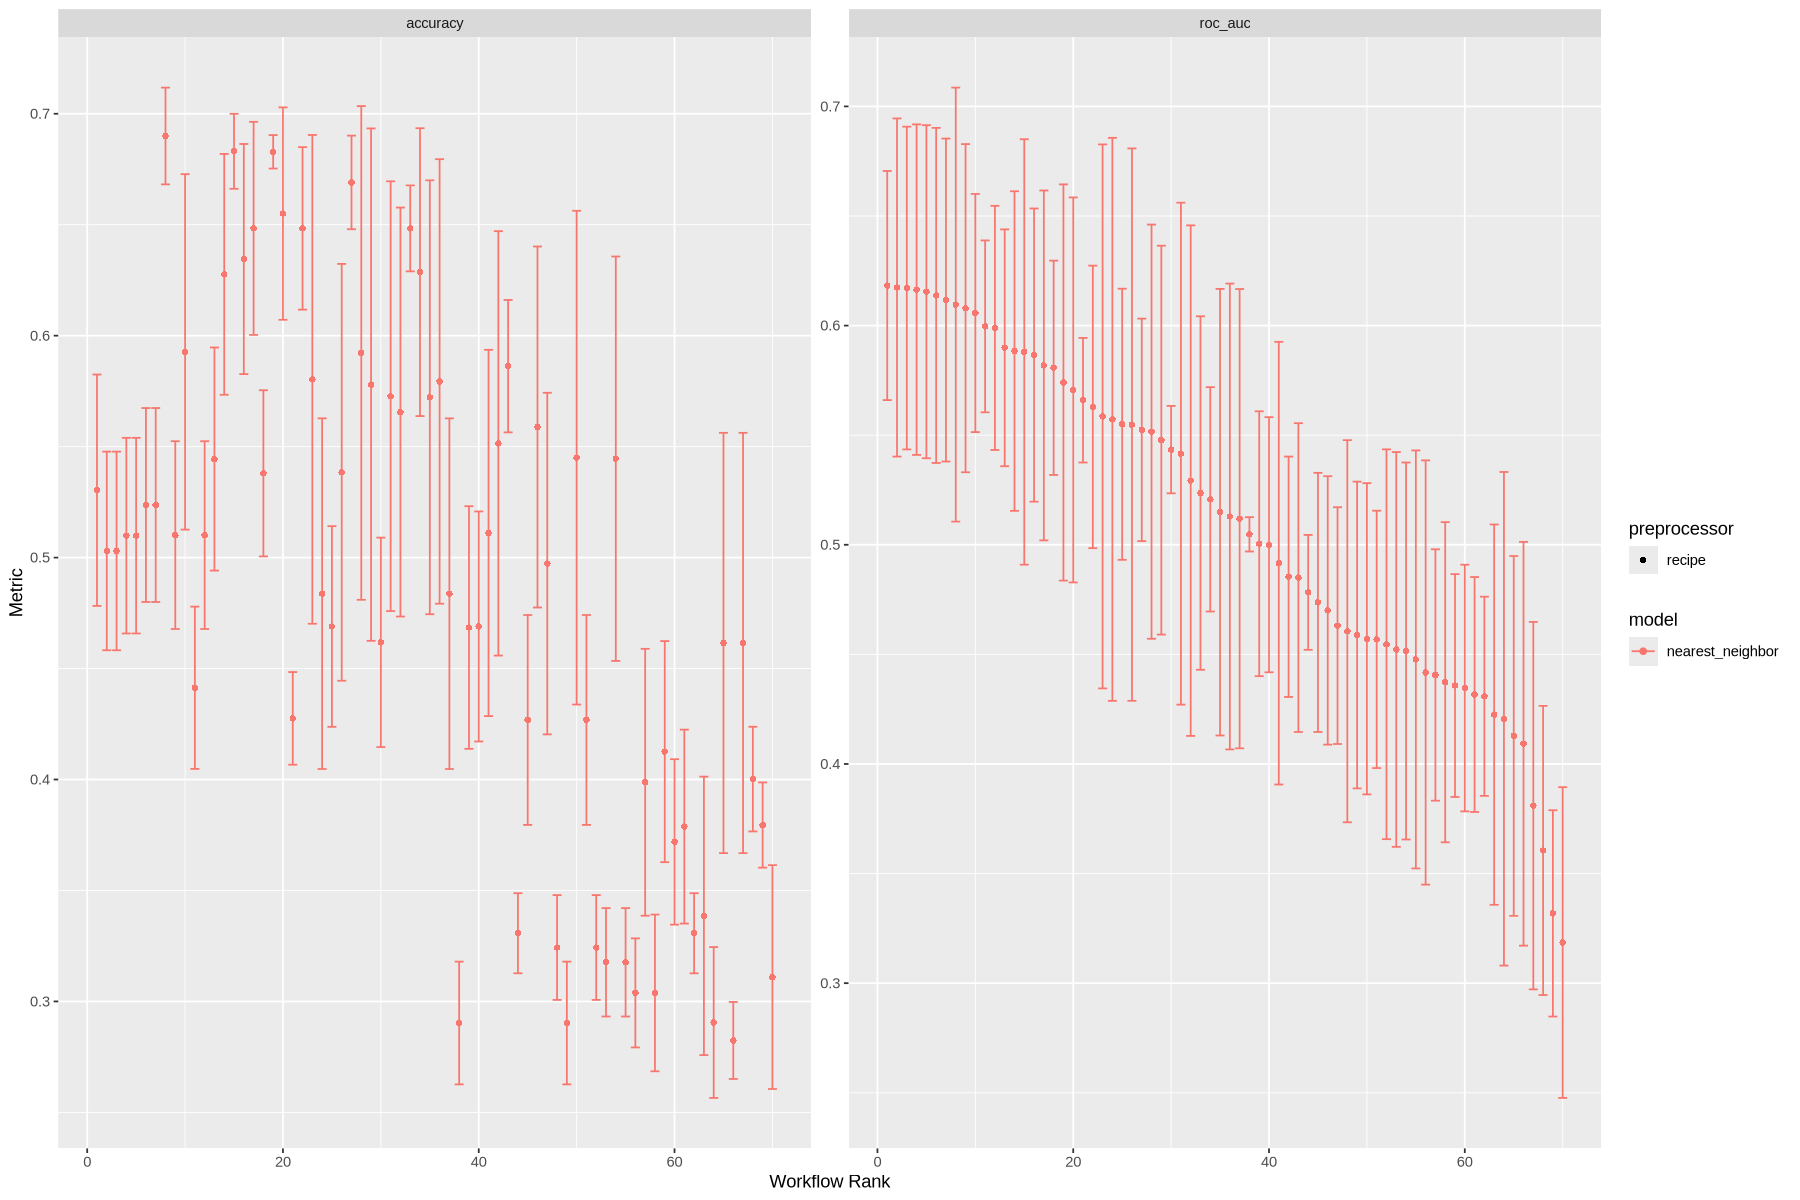

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.matrix.max.rows = 10)

# Tune Step
knn_res <- collect_metrics(ply_set_res)
# knn_res
autoplot(ply_set_res)


In [16]:
#TODO DELETE TMP just rough set up 
# accuracies <- knn_res |>
#             filter(.metric == "accuracy")

# cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
#                   geom_point() +
#                   geom_line() +
#                   labs(x = 'Neighbors', y = 'Accuracy Estimate')


# cross_val_plot

### Player Type Exploration: "TODO may need renaming"

## Discussion:

In [17]:
# Ref 
# Data Science programming techniques and approaches:
# Clustering prediction: https://www.youtube.com/watch?v=z57i2GVcdww
# Simplifying multi model set up + testing: https://www.youtube.com/watch?v=YZqbOATpjM4
# Tuning and comparing models using Workflowse: https://workflowsets.tidymodels.org/articles/tuning-and-comparing-models.html

In [18]:
#TODO tmp info grounds

